# TextMining CW2
### Jie Wang &emsp; Rong Jian Yee &emsp; Hao Cao &emsp; Zhiyuan Zhao

### Main Tasks
1. What is the domiant sentiment towards large language models such as OpenAI's ChatGPT and others?
2. What are the pros and cons of these large language models that people have been discussing?
3. What field will large language models be most beneficial and useful in the future?

---

# Data generating

1. using the API search_tweets of version 4.0+ to acquire the data from twitter.
2. convert all tweets from list to dataframe.
3. store the data in csv file.

In [3]:
import tweepy
import pandas as pd
import time

auth = tweepy.OAuthHandler('BcWEliOxF0h6v9VWpUlNtS5nU', 'HfW6WHnnPqB5BkodYKgMTAihGbmEjioJpP3DhAekLLtVeb6xIi')
auth.set_access_token('841021709209731073-rRR8mlOkIw7pLGEnplp03nWwnYOGwJ3', 'Aa2c8dlmUOKzsRRRc0v6gELtKbJFAkcNwNzOe9T6uuCUQ')

api = tweepy.API(auth, wait_on_rate_limit=True) #

# Collect tweets
query = "#chatgpt" + " -filter:retweets"
# cutoff_date = "2023-03-05"
tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", count=100).items(2000)

tweets_list = [[tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

tweets_df = pd.DataFrame(data=tweets_list, columns=['date', 'user', 'location', 'text'])

# A good idea to save downloaded tweets as CSV
tweets_df.to_csv ('./resources/chatgpt.csv', quotechar='"', encoding='utf8', index = False, header=True)
print("Finish data generation.")

Rate limit reached. Sleeping for: 603


Finish data generation.


---

# Data cleaning

1. Mainly using the regular expression to do the data cleaning.
2. utilising the set to remove the duplicate tweets.

In [6]:
# Load the regular expression library
import re
import pandas as pd

# Make sure that line below is uncommented, if you are loading data from a provided/previously saved CSV
tweets_df = pd.read_csv('./resources/chatgpt.csv', quotechar='"', encoding='utf8')

# Remind the type of 'text' column, convert to string before using the map
tweets_df['text'] = tweets_df['text'].values.astype(str)

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text'].map(lambda x: re.sub('[,\\.!?]', ' ', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: x.lower())

# Strip the https
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'https://t [a-zA-Z+]*','',x))

#Strip the senseless pattern
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'/[A-Za-z0-9]*','',x))

# pattern of emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)

# Strip the emoji
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: emoji_pattern.sub(r'',x))

# Think of how else your data can be cleaned

# Set the option to display full details of processed string
pd.set_option('display.max_colwidth', None)

# Print out the first rows 
print(tweets_df['text_processed'].head())

# Removing duplicate tweets?
unique_tweets = list(set(list(tweets_df['text_processed'].values)))
unique_tweets = [t for t in unique_tweets if t]

# print(unique_tweets)

0     #weatherupdate #islamabad #isb #pakistan #tempupdate #sunrise #sunset #hourlyupdatesunrise: 06:24 am sunset: 06:11… 
1    we use #ai in our lives all the time  but with tools like #chatgpt trending  there's new dialogue around what it me… 
2          for #chatgpt the limits of its language (model) are the limits of its world  - wittgenstein was right (again)  
3    respecting the rule of law  and promoting unity and dialogue  rather than promoting or advocating for violence or c… 
4                      how to use chatgpt to unlock new levels of innovation#entrepreneurship #chatgpt #innovation #levels
Name: text_processed, dtype: object


---

# Using word cloud

1. try to generate the word cloud of previous tweets.

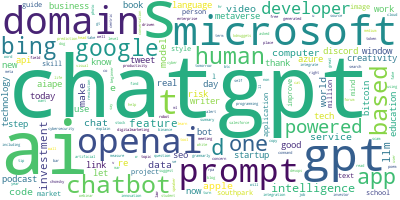

In [7]:
from wordcloud import WordCloud

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

---

# Topic Modelling

1. download the nltk stopwords.
2. use the gensim to do simple preprocess of sentences.
3. remove the stopwords in sentences.

In [8]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

# Do you want to modify this by adding more stop words?
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]


data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from pprint import pprint

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"chatgpt" + 0.030*"ai" + 0.012*"new" + 0.011*"gpt" + 0.010*"openai" + '
  '0.005*"get" + 0.005*"data" + 0.005*"amp" + 0.004*"chat" + '
  '0.004*"highlights"'),
 (1,
  '0.071*"chatgpt" + 0.010*"ai" + 0.008*"openai" + 0.007*"microsoft" + '
  '0.004*"one" + 0.004*"first" + 0.004*"know" + 0.004*"time" + 0.003*"today" + '
  '0.003*"gpt"'),
 (2,
  '0.056*"chatgpt" + 0.035*"ai" + 0.012*"chatbot" + 0.011*"chatgptprompts" + '
  '0.011*"aichatbot" + 0.011*"email" + 0.011*"chatbotai" + 0.011*"like" + '
  '0.009*"marketing" + 0.007*"laws"'),
 (3,
  '0.071*"chatgpt" + 0.028*"ai" + 0.007*"like" + 0.006*"new" + 0.006*"tools" + '
  '0.006*"openai" + 0.006*"microsoft" + 0.005*"amp" + 0.004*"world" + '
  '0.004*"using"'),
 (4,
  '0.025*"chatgpt" + 0.012*"ai" + 0.006*"openai" + 0.005*"amp" + 0.003*"like" '
  '+ 0.003*"gpt" + 0.003*"via" + 0.003*"hype" + 0.003*"great" + '
  '0.002*"prompts"')]


# visualise the topics

1. set the data filepath.
2. save the data at the resources folder.
3. load the data file and generate the LDAvis.

In [13]:
import os
import pyLDAvis.gensim as gensimvis  #remind that pyLDAvis.gensim_models is newer one
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./resources/'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './resources/'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.031267 -0.069543       1        1  27.355386
3      0.026591 -0.028587       2        1  23.402390
2     -0.114355 -0.019359       3        1  20.194073
1      0.070337  0.027879       4        1  19.264523
4     -0.013840  0.089609       5        1   9.783628, topic_info=                Term       Freq      Total Category  logprob  loglift
2160       aichatbot  43.000000  43.000000  Default  30.0000  30.0000
2161       chatbotai  43.000000  43.000000  Default  29.0000  29.0000
2162  chatgptprompts  44.000000  44.000000  Default  28.0000  28.0000
2163           email  44.000000  44.000000  Default  27.0000  27.0000
99           chatbot  71.000000  71.000000  Default  26.0000  26.0000
...              ...        ...        ...      ...      ...      ...
177             data   3.081186  45.396585   Topic5  -6.4109  -0.3657
673            asked   3.004736  38.043251   Topic5  -6.4360  -0.2141
911              one   2.996904  40.618293   Topic5  -6.4386  -0.2822
347             week   2.966594  42.340429   Topic5  -6.4488  -0.3339
694             need   2.871585  23.702022   Topic5  -6.4814   0.2138

[356 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2558      1  0.281052   actions
2558      5  0.562104   actions
285       4  0.870717       ads
1817      1  0.230987  advanced
1817      4  0.230987  advanced
...     ...       ...       ...
937       1  0.116758   youtube
937       2  0.700549   youtube
937       4  0.233516   youtube
1893      2  0.645021      zyte
1894      2  0.645024    zyteai

[707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

---

# Sentiment Analysis

1. install the vaderSentiment.
2. use the analyzer.

In [45]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a dictionary for the results.
vsResults = {}

# Count for the dictionary
count = 0

for tweet_text in unique_tweets:
    vs = analyzer.polarity_scores(tweet_text)
    vsResults[count] = [tweet_text,vs]
    count += 1
#     print(tweet_text + '\t' + str(vs))

# The volumn of the tweets, equals to the variable count
volumn = count

# Just print to observe the results
for i in range(10):
    print(str(i)+":  ",str(vsResults[i][0])+"\t"+str(vsResults[i][1]))
    
# Create the dictionary of final result for four sentiments
sentimentResults = {'neg':0.0,'neu':0.0,'pos':0.0,'compound':0.0}
# Calculate the general sentiment of the tweets about chatgpt
for i in range(volumn):
    sentimentResults['neg'] += float(vsResults[i][1]['neg'])
    sentimentResults['neu'] += float(vsResults[i][1]['neu'])
    sentimentResults['pos'] += float(vsResults[i][1]['pos'])
    sentimentResults['compound'] += float(vsResults[i][1]['compound'])
    
print("\nThe main sentiment towards ChatGPT is: ",max(sentimentResults))

0:   three mile island has a clean-up cost that is higher than the construction cost of the plant itself #chatgpt	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
1:   chatgpt prompts: your gateway to crafting unforgettable stories from mystery and suspense prompts to historical… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
2:   there’s been a lot of chat about chatgpt in the press; we had a ‘virtual’ sit down with #chatgpt to find out how it… 	{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
3:   if you chatgpt isn't showing your recent history  don't panic  just logout to your account  again logged in and boo… 	{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'compound': 0.4023}
4:   @crypto_bitlord7 are you tired of rugs  @zyteai got you  #zyte is building autonomous tools to help manage risk on… 	{'neg': 0.211, 'neu': 0.675, 'pos': 0.114, 'compound': -0.3182}
5:   hey @microsoft how about a @openai #chatgpt in a #googlehome or an #alexa - you can call it "mai"    you ar

---

# Named Entity Recognition

1. install the spacy.
2. load the nlp model.
3. get the result of nlp model.

In [30]:
import spacy
import en_core_web_trf

nlp = spacy.load('en_core_web_trf')

/Users/jiewang/opt/anaconda3/envs/dataEngineering/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'en_core_web_trf'

In [ ]:
for tweet_text in unique_tweets:
  doc = nlp(tweet_text)
  print(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, tweet_text[ne.start_char:ne.end_char])